# 데이터 준비

In [13]:
from keras_unet.models import custom_unet
from keras_unet.utils import plot_imgs
from Dataset import Dataset
import numpy as np
import matplotlib.pyplot as plt
import os

dataset = Dataset("./ChestCT_GT")
dcms = []
masks = []

### 데이터에 관한 사전 정보 정의

* 모델 학습에 사용되는 데이터에 대한 경로/Resize 크기 등 사전 정보를 정의
* (수정사항) 영상 resize 크기 및 클래스 개수는 변수로 정의하였습니다.

In [14]:
target_input_shape = (256, 256)
num_classes = 1

### 데이터 로드
* DICOM 및 레이블 영상을 읽고, 영상의 크기를 target_input_shape 에 정의한 크기로 변환
* 레이블영상은 One-hot encoding 수행

In [15]:
for dcm, mask in zip(dataset.dicoms, dataset.masks):
    dcms.append(dcm.pixel_array)
    masks.append(mask)

In [16]:
from skimage.transform import resize

# resize image (512, 512) -> (256, 256)
dcms_resize = []
masks_resize = []
for idx, (dcm, mask) in enumerate(zip(dcms, masks)):
    dcm_resized = resize(dcm, target_input_shape, order=0, preserve_range=True, anti_aliasing=False).astype('int16')
    dcms_resize.append(dcm_resized)

    mask_resized = resize(mask, target_input_shape, order=0, preserve_range=True, anti_aliasing=False).astype('float32')
    muscle = np.equal(mask_resized, 2) * 1
    masks_resize.append(muscle)

In [17]:
x = np.asarray(dcms_resize)
y = np.asarray(masks_resize)

Text(0.5, 1.0, 'Label overlay image')

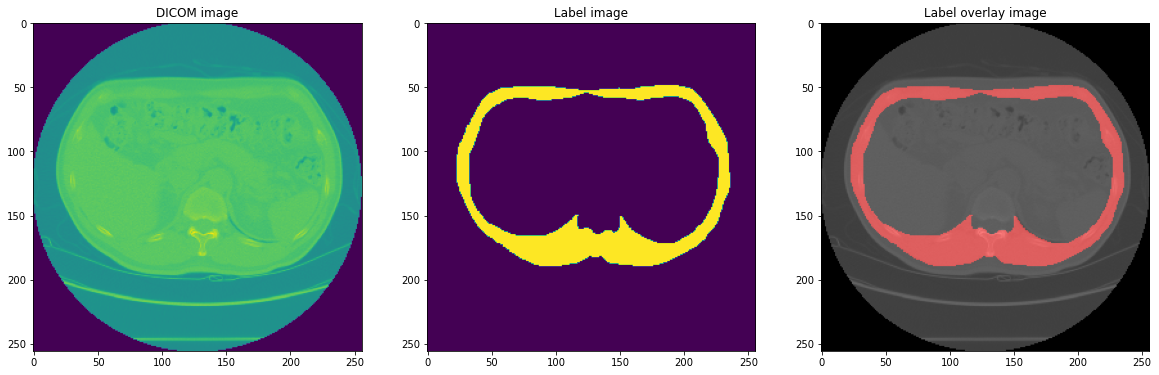

In [18]:
from skimage import color

target_data_idx = 0
dcm_img = x[target_data_idx]
normalized_dcm_img = ((dcm_img - dcm_img.min()) /  (dcm_img.max() - dcm_img.min())) # 0-1 범위로 정규화
mask_img = y[target_data_idx]
overlay_img = color.label2rgb(mask_img, normalized_dcm_img, bg_label=0, alpha = 0.5) # dcm 영상에 레이블 영상을 오버레이
# DCM/Label/Overlay 영상 출력
fig, m_axs = plt.subplots(1, 3, figsize = (20, 20))
m_axs[0].imshow(dcm_img)
m_axs[0].set_title('DICOM image')

m_axs[1].imshow(mask_img)
m_axs[1].set_title('Label image')

m_axs[2].imshow(overlay_img)
m_axs[2].set_title('Label overlay image')

In [19]:
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
y = y.reshape(y.shape[0], y.shape[1], y.shape[2] ,1)

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=0)

print('x_train: ', x_train.shape)
print('y_train: ', y_train.shape)
print('x_val: ', x_val.shape)
print('y_val: ', y_val.shape)

x_train:  (611, 256, 256, 1)
y_train:  (611, 256, 256, 1)
x_val:  (262, 256, 256, 1)
y_val:  (262, 256, 256, 1)


# dataset augmentation
* keras-unet의 get_augmented 이용해 dataset augementation 진행

In [21]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=5,
    data_gen_args= dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
    )
)


In [22]:
from skimage import color

sample_batch = next(train_gen)
xx, yy = sample_batch

In [23]:
target_data_idx = 0
dcm_img = xx[target_data_idx]
normalized_dcm_img = ((dcm_img - dcm_img.min()) /  (dcm_img.max() - dcm_img.min())) # 0-1 범위로 정규화
normalized_dcm_img = normalized_dcm_img.reshape(normalized_dcm_img.shape[0], normalized_dcm_img.shape[1])
mask_img = yy[target_data_idx]
mask_img = mask_img.reshape(mask_img.shape[0], mask_img.shape[1])
print(mask_img.shape, normalized_dcm_img.shape)

(256, 256) (256, 256)


Text(0.5, 1.0, 'Label overlay image')

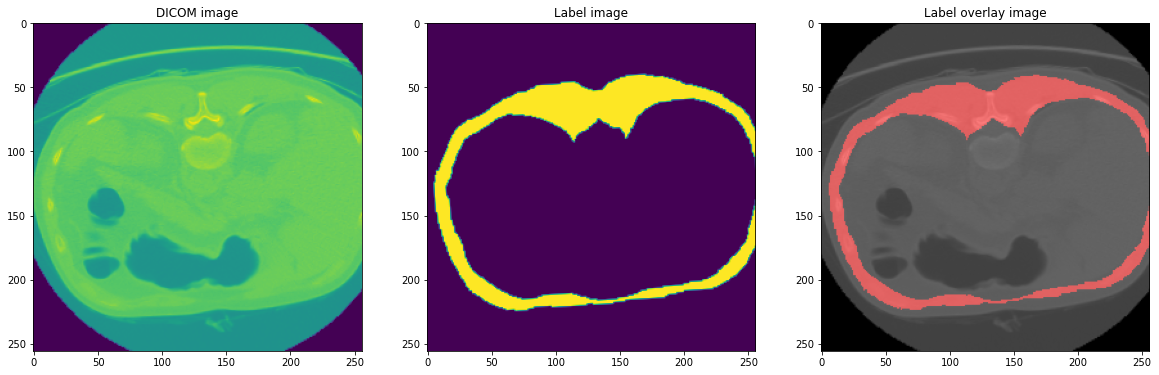

In [24]:
overlay_dcm_img = color.label2rgb(mask_img, normalized_dcm_img, bg_label=0, alpha = 0.5) # dcm 영상에 레이블 영상을 오버레이

# DCM/Label/Overlay 영상 출력
fig, m_axs = plt.subplots(1, 3, figsize = (20, 20))
m_axs[0].imshow(dcm_img)
m_axs[0].set_title('DICOM image')

m_axs[1].imshow(mask_img)
m_axs[1].set_title('Label image')

m_axs[2].imshow(overlay_dcm_img)
m_axs[2].set_title('Label overlay image')

# 학습 모델 정의
* 학습에 사용될 딥러닝 분할 네트워크 구성 및 Hyperparameter 정의

In [25]:
from keras_unet.models import custom_unet

input_shape = x_train[0].shape

model = custom_unet(
    input_shape,
    use_batch_norm=True,
    num_classes=1,
    filters=8,
    dropout=0.2,
    output_activation='sigmoid'
)

In [26]:
import sys

os.environ["PATH"] += os.pathsep + "C:\\Program Files (x86)\\Graphviz\\bin"
print(sys.path)

sys.path.append("C:\\Program Files (x86)\\Graphviz\\bin")
print(sys.path)

['C:\\Users\\user\\Desktop\\ComputingAcademy', 'C:\\Users\\user\\Desktop\\ComputingAcademy', 'C:\\Users\\user\\anaconda3\\envs\\Project\\python38.zip', 'C:\\Users\\user\\anaconda3\\envs\\Project\\DLLs', 'C:\\Users\\user\\anaconda3\\envs\\Project\\lib', 'C:\\Users\\user\\anaconda3\\envs\\Project', '', 'C:\\Users\\user\\anaconda3\\envs\\Project\\lib\\site-packages', 'C:\\Users\\user\\anaconda3\\envs\\Project\\lib\\site-packages\\mask_rcnn-2.1-py3.8.egg', 'C:\\Users\\user\\anaconda3\\envs\\Project\\lib\\site-packages\\locket-0.2.1-py3.8.egg', 'C:\\Users\\user\\anaconda3\\envs\\Project\\lib\\site-packages\\win32', 'C:\\Users\\user\\anaconda3\\envs\\Project\\lib\\site-packages\\win32\\lib', 'C:\\Users\\user\\anaconda3\\envs\\Project\\lib\\site-packages\\Pythonwin', 'C:\\Users\\user\\anaconda3\\envs\\Project\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\user\\.ipython', 'C:\\Program Files\\JetBrains\\PyCharm 2021.2.2\\plugins\\python\\helpers\\pydev', 'C:\\Program Files\\JetBrains\\

In [27]:
# keras.utils.plot_model -> keras.utils.vis_utils.plot_model
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [28]:
from keras.callbacks import ModelCheckpoint

model_filename = 'muscle_batch_segm_model_v0.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename,
    verbose=1,
    monitor='val_loss',
    save_best_only=True,
)

### Loss/Optimizer/Metric 정의

* 2개 레이블로 구성된 데이터를 학습 -  binary_crossentropy 사용
* 3개 이상의 레이블로 구성된 데이터를 학습 - categorical_crossentropy 사용
  + sparse_categorical_crossentorpy는 학습에 사용되는 정답 데이터가 one-hot 형태가 아닌 label 형태인 경우 사용

In [29]:
from tensorflow import keras
import tensorflow
from keras_unet.metrics import iou, iou_thresholded, dice_coef, jaccard_coef

model.compile(
    optimizer=tensorflow.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy', iou, iou_thresholded, dice_coef],
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 256, 256, 8)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

# generated 모델 학습

In [30]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)

C:\Users\user\anaconda3\envs\Project\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
100/100 [==============================] - 10s 52ms/step - loss: 0.4942 - accuracy: 0.8425 - iou: 0.2118 - iou_thresholded: 0.4578 - dice_coef: 0.3475 - val_loss: 0.8190 - val_accuracy: 0.8276 - val_iou: 0.1575 - val_iou_thresholded: 0.2175 - val_dice_coef: 0.2719

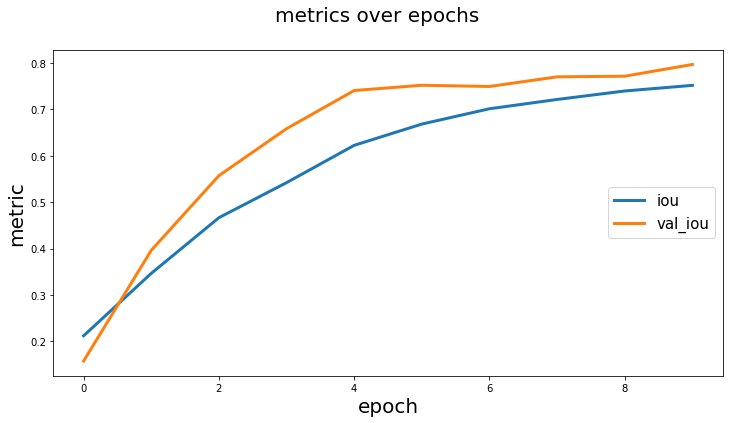

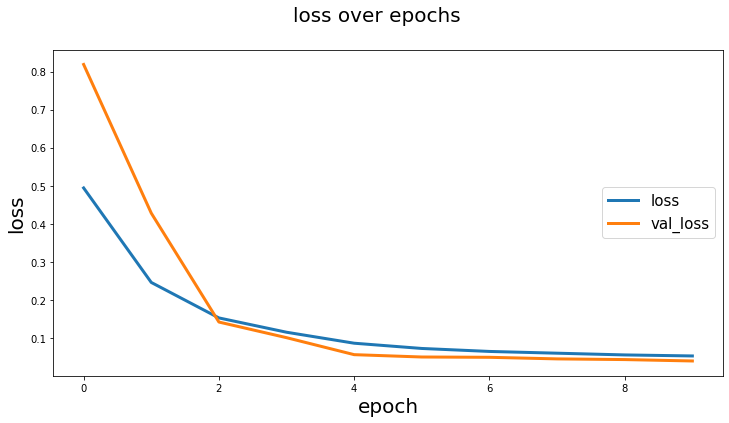

In [33]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)


### 데이터 테스트

In [34]:
model.load_weights(model_filename)
y_pred = model.predict(x_val)

### 테스트 결과 출력

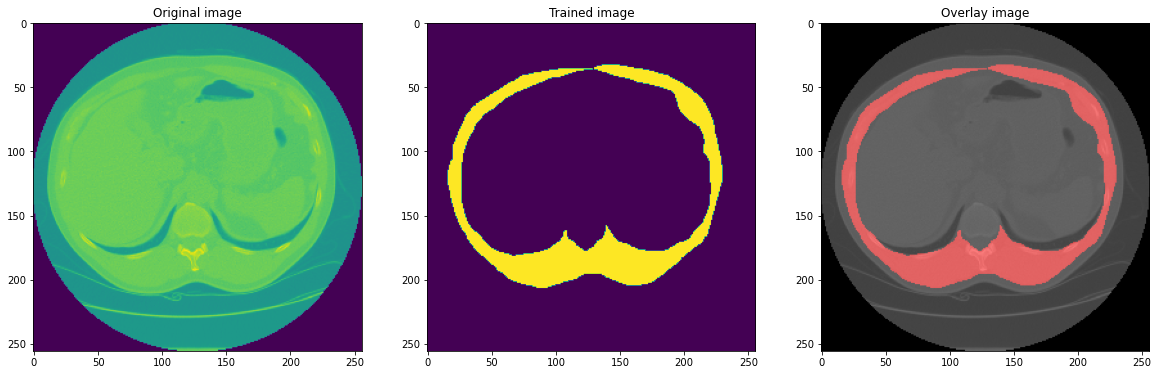

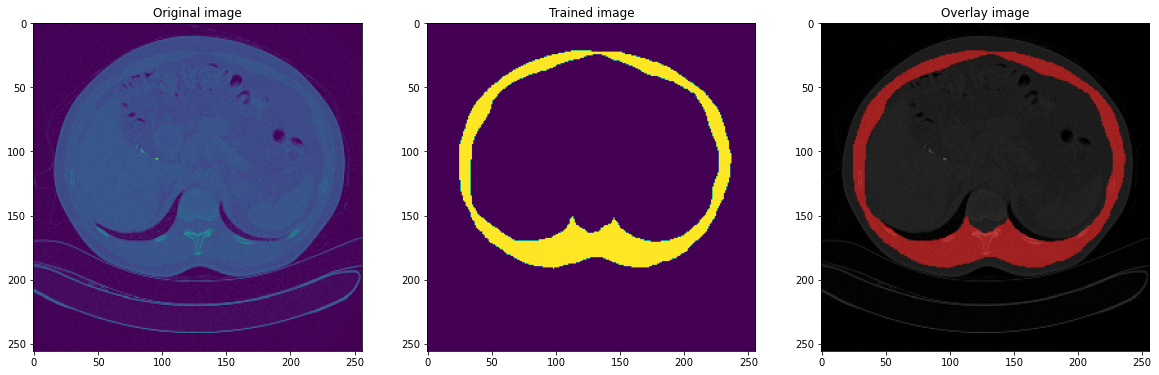

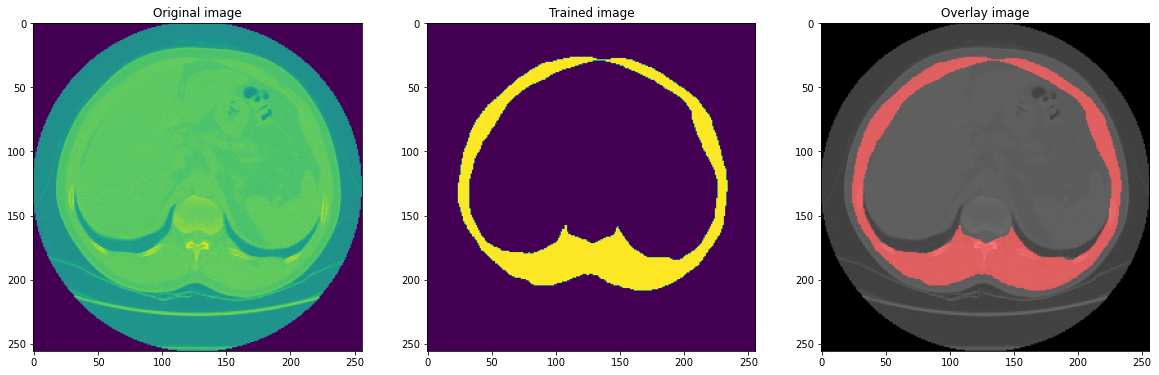

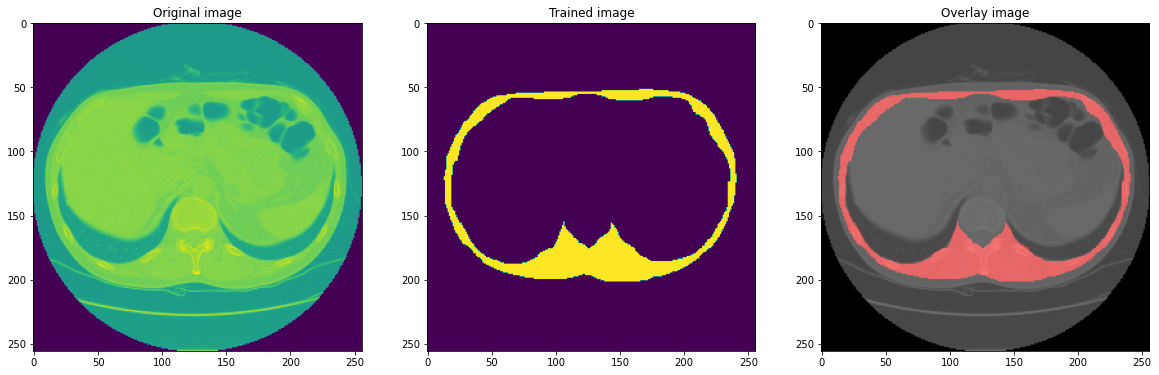

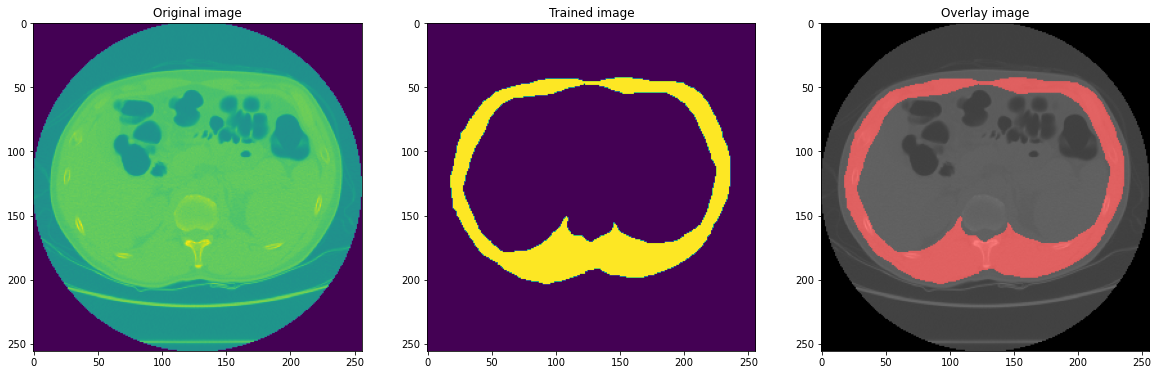

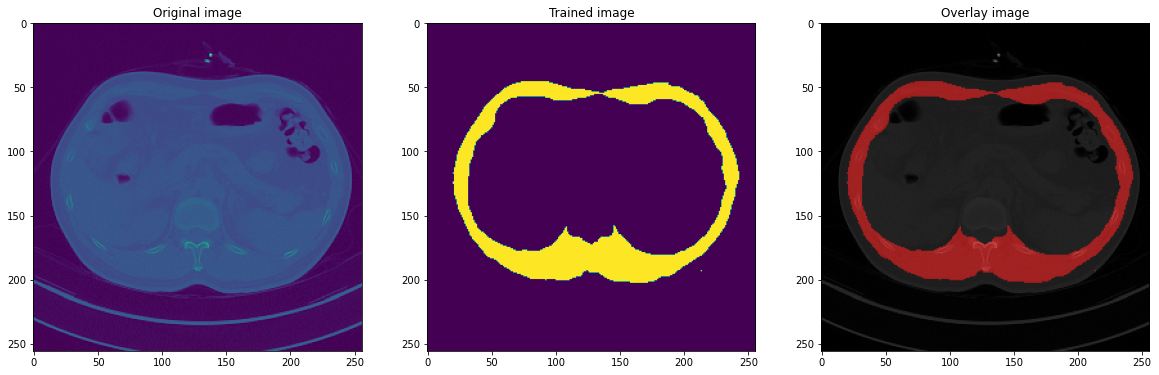

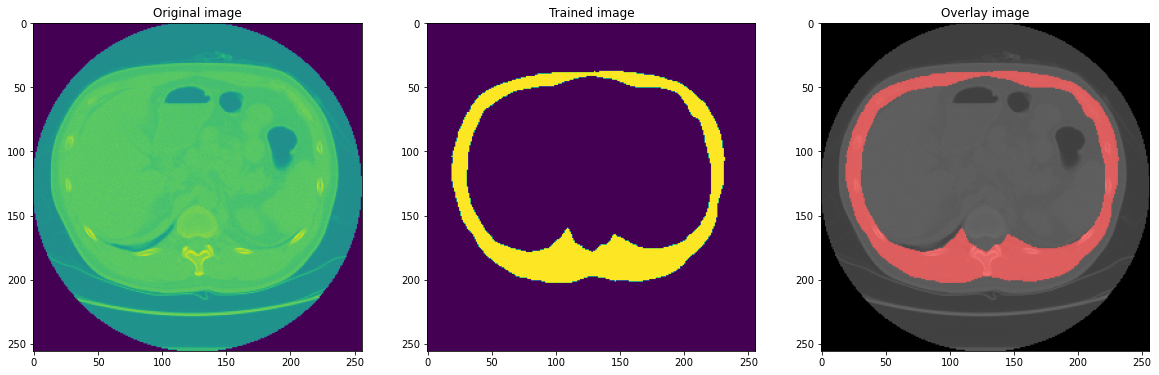

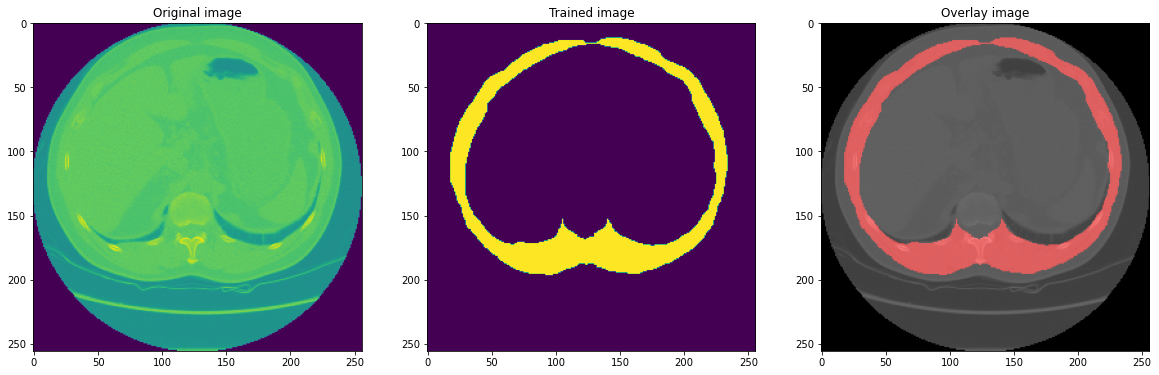

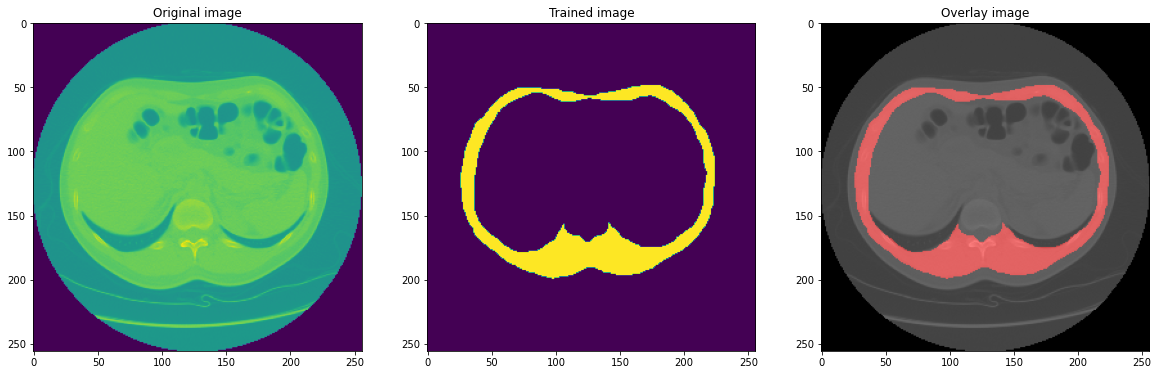

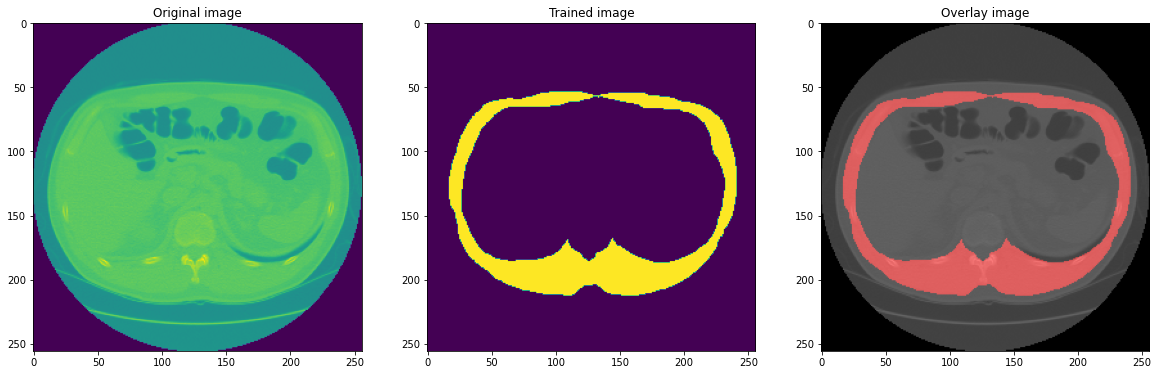

In [35]:
from skimage import color

for idx in range(10):
    target_data_idx = idx
    x_img = x_val[target_data_idx]
    x_img = x_img.reshape(x_img.shape[0], x_img.shape[1])
    normalized_x_img = ((x_img - x_img.min()) /  (x_img.max() - x_img.min())) # 0-1 범위로 정규화
    y_img = y_val[target_data_idx]
    y_img = y_img.reshape(y_img.shape[0], y_img.shape[1])
    overlay_img = color.label2rgb(y_img, normalized_x_img, bg_label=0, alpha = 0.5) # dcm 영상에 레이블 영상을 오버레이

    # DCM/Label/Overlay 영상 출력
    fig, m_axs = plt.subplots(1, 3, figsize = (20, 20))
    m_axs[0].imshow(x_img)
    m_axs[0].set_title('Original image')

    m_axs[1].imshow(y_img)
    m_axs[1].set_title('Trained image')

    m_axs[2].imshow(overlay_img)
    m_axs[2].set_title('Overlay image')

In [37]:
accuracy_list = history.history['val_accuracy']
print('accuracy std: ', np.std(accuracy_list))
iou_std = history.history['val_iou']
print('iou std: ', np.std(iou_std))
dsc_std = history.history['val_dice_coef']
print('dsc std: ', np.std(dsc_std))

accuracy std:  0.04700723752688556
iou std:  0.19821657273732718
dsc std:  0.1860728652650771


In [38]:
# 모델 평가
score = model.evaluate(x_val, y_val, verbose=1)
print('accuracy=', score[1], 'loss=', score[0])
print(np.std(score[1]))
print('IoU=', score[2])
print(np.std(score[2]))
print('DICE', score[3])
print(np.std(score[3]))



9/9 [==============================] - 1s 38ms/step - loss: 0.0392 - accuracy: 0.9854 - iou: 0.7969 - iou_thresholded: 0.8775 - dice_coef: 0.8870
accuracy= 0.9853973388671875 loss= 0.0392029769718647
0.0
IoU= 0.7969456911087036
0.0
DICE 0.8774725198745728
0.0
